In [100]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [483]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Dataset
import os
import cv2
from PIL import Image
%matplotlib inline

In [577]:
my_transforms = transforms.Compose([
    #ToTensor(),
    #transforms.ToPILImage(),
    transforms.Resize((90,90)),
    transforms.Grayscale(),
    ToTensor()
])

my_transforms_aug1 = transforms.Compose([
    #ToTensor(),
    #transforms.ToPILImage(),
    transforms.Resize((90,90)),
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(1),
    ToTensor()
])

my_transforms_aug2 = transforms.Compose([
    #ToTensor(),
    #transforms.ToPILImage(),
    transforms.Resize((90,90)),
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(25),
    ToTensor()
])

In [578]:
#untransformed image dataset
dataset2 = torchvision.datasets.ImageFolder(r"D:\cats-dogs-dataset\test_set\test_set", transform = ToTensor())

#transformed image dataset
dataset = torchvision.datasets.ImageFolder(r"D:\cats-dogs-dataset\test_set\test_set", transform = my_transforms)
#OHE_labels = 

dataset_aug1 = torchvision.datasets.ImageFolder(r"D:\cats-dogs-dataset\test_set\test_set", transform = my_transforms_aug1)
dataset_aug2 = torchvision.datasets.ImageFolder(r"D:\cats-dogs-dataset\test_set\test_set", transform = my_transforms_aug2)

dataset[100][1]

0

In [579]:
import random
#images, labels = dataset
imageRand, labelRand = dataset[random.randint(0,2022)]
#print(image.shape)
#print(label)
#print(dataset.classes)
#dataset[100][1] #this is how to reference tuples
print(dataset[100][0].shape)
#len(dataset)

torch.Size([1, 90, 90])


In [580]:
def show_example(img, label = None):
    if label is not None:
        print(f"Label: {dataset.classes[label]}")
    if img.shape[0] == 1:
        plt.imshow(torch.squeeze(img))
    if img.shape[0] == 3:
        plt.imshow(img.permute(1,2,0))
    print(img.shape)

Label: cats
torch.Size([1, 90, 90])


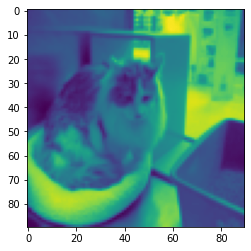

In [584]:
index = random.randint(0,2022)
imageRand, labelRand = dataset[index]
show_example(imageRand, labelRand)

Label: cats
torch.Size([1, 90, 90])


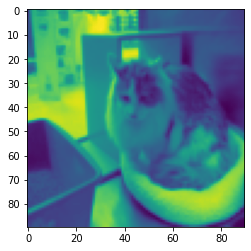

In [586]:
imageRand2, labelRand2 = dataset_aug1[index]
show_example(imageRand2, labelRand2)

Label: cats
torch.Size([1, 90, 90])


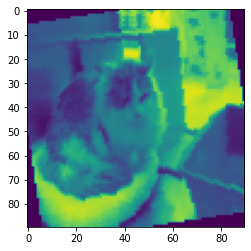

In [587]:
imageRand3, labelRand3 = dataset_aug2[index]
show_example(imageRand3, labelRand3)

Label: cats
torch.Size([3, 375, 499])


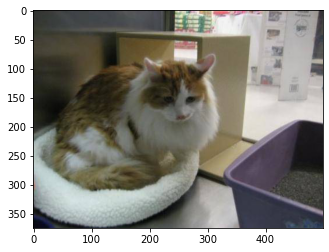

In [588]:
#non-modified image
imageRand4, labelRand4 = dataset2[index]
show_example(imageRand4, labelRand4)

In [589]:
val_size = int(len(dataset) * 0.2)
train_size = len(dataset) - val_size

train_ds1, val_ds = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(1232))
train_ds2, _ = random_split(dataset_aug1, [train_size, val_size], generator=torch.Generator().manual_seed(1232))
train_ds3, _ = random_split(dataset_aug2, [train_size, val_size], generator=torch.Generator().manual_seed(1232))


train_ds = torch.utils.data.ConcatDataset([train_ds1, train_ds2, train_ds3])
len(train_ds), len(val_ds)

(4857, 404)

In [590]:
from torch.utils.data.dataloader import DataLoader

batch_size=64

In [591]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
train_dl_assess = DataLoader(train_ds, len(train_ds), shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, len(val_ds), num_workers=4, pin_memory=True)

In [592]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
        
def show_batch_size(dl):
    for images, labels in dl:
        print(images.shape)
        print(labels)
        #print(extra)
        break

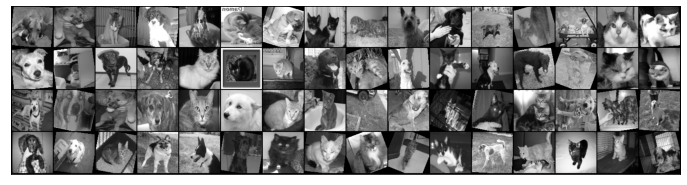

In [593]:
show_batch(train_dl)

In [594]:
class catVsDogModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
           # input: 3 * 90 * 90
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # output: 16 x 45 x 45
            #nn.BatchNorm2d(16),
            
           # nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
           # nn.ReLU(),
           # nn.MaxPool2d(2, 2), # output: 32 x 32 x 32

           # nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
           # nn.ReLU(),
           # nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

           # nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
           # nn.ReLU(),
           # nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(16*45*45, 20),
            #nn.BatchNorm1d(20), cant get this thing to not give nans
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(20,2),
            #nn.Softmax(dim=1) nn.CrossEntropyLoss already applies softmax in training
        )
    
    def forward(self, xb):
        return self.network(xb)

In [595]:
model = catVsDogModel()
model.eval()
index2 = random.randint(0,2022)
images, labels = dataset[index2]
images = torch.unsqueeze(images, 0)
print('image:', images.shape)
out = model(images)
print('out.shape:', out.shape)
print('out:', out)
model


image: torch.Size([1, 1, 90, 90])
out.shape: torch.Size([1, 2])
out: tensor([[-0.0787, -0.1684]], grad_fn=<AddmmBackward>)


catVsDogModel(
  (network): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=32400, out_features=20, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [599]:
def singlePrediction(image, label = None):
    model.eval()
    probs = nn.Softmax(dim=1)
    show_example(image, label)
    image = torch.unsqueeze(image, 0)
    out = model(image)
    out = probs(out)
    print(out)
    prob, index = torch.max(out, dim = 1)
    print("Model prediction:", dataset.classes[index])
    print("Probability of correctness:", prob.item())
    if label is not None:
        print(f"Correct class: {dataset.classes[label]}")
    

Label: dogs
torch.Size([1, 90, 90])
tensor([[0.5369, 0.4631]], grad_fn=<SoftmaxBackward>)
Model prediction: cats
Probability of correctness: 0.5368946194648743
Correct class: dogs


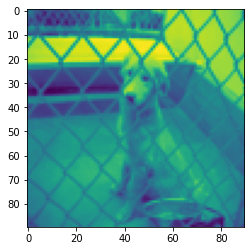

In [603]:
index2 = random.randint(0,403)
image, label = val_ds[index2]
singlePrediction(image, label)

In [613]:
#loss function, optimizer and other parameters
learning_rate = 0.05
criterion = nn.CrossEntropyLoss()
alpha = 0.0000
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay=alpha)
num_epochs = 100

In [614]:
def evaluate(model, val_dl):
    model.eval()
    for batch in val_dl:
        images, labels = batch
    with torch.no_grad():
        y_predicted = model(images)
        #print(y_predicted)
        _, y_predicted_class = torch.max(y_predicted, dim = 1)
        correct_predictions = torch.sum(y_predicted_class == labels).item()
        return (correct_predictions/len(y_predicted))

In [615]:
def loss_eval(model, val_dl):
    model.eval()
    for batch in val_dl:
        images, labels = batch
    with torch.no_grad():
        y_predicted = model(images)
        return criterion(y_predicted, labels)

In [616]:
def train_model(model, optimizer, criterion, num_epochs, train_losses = None):    
    for epoch in range(num_epochs):
        model.train()
        for batch in train_dl:

            # forward pass and loss
            image, labels = batch
            y_predicted = model(image)
            loss = criterion(y_predicted, labels) #does this really work without one-hot enconding?

            # backward pass
            loss.backward()

            #updates
            optimizer.step()

            # reset gradients
            optimizer.zero_grad()

            #if (epoch + 1) % 10 == 0:
                #print(f"epoch: {epoch + 1}, loss = {loss.item():.4f}")
        if train_losses is not None:
            model.eval()
            with torch.no_grad():
                if ((epoch + 1)  % 10) == 0:
                    train_losses.append(loss_eval(model, train_dl_assess).item())


In [620]:
train_model(model, optimizer, criterion, num_epochs, loss_list_0000)

In [621]:
print(loss_list_0000)

[0.6759174466133118, 0.6370791792869568, 0.5704272985458374, 0.5192884206771851, 0.4665956199169159, 0.4189133048057556, 0.32816317677497864, 0.32306286692619324, 0.29672884941101074, 0.27189356088638306, 0.2500894069671631, 0.24624386429786682, 0.21759986877441406, 0.21200032532215118, 0.20835523307323456, 0.20163902640342712, 0.2003449648618698, 0.18280881643295288, 0.1911756992340088, 0.18470145761966705]


In [622]:
print(f'Training accuracy: {evaluate(model, train_dl_assess)}')
print(f'Validation accuracy: {evaluate(model, val_dl)}')


Training accuracy: 0.9250566193123327
Validation accuracy: 0.693069306930693


In [289]:
Learning rate: 0.05
Regularisation 120 epochs trainig val accuracy results:
    No regularisation: Training accuracy: 1.0    Validation accuracy: 0.5544554455445545
    0.0001: 
    0.0003:
    0.001: 
    0.003: Training accuracy: 0.8418777022853613  Validation accuracy: 0.5099009900990099
    0.01: Training accuracy: 0.9320568252007412  Validation accuracy: 0.564356435643564
    0.03: 
    0.1: 
        
        
        0.5 dropout: 100 epochs: Training accuracy: 0.9036442248301421 Validation accuracy: 0.599009900990099
                     200 epochs: Training accuracy: 1.0 Validation accuracy: 0.6534653465346535 This seems to be the limit for rgb images
                                
with dropout and image augmentation:
    100 epochs: Training accuracy: 0.8999382334774553  Validation accuracy: 0.6881188118811881

SyntaxError: invalid syntax (<ipython-input-289-4af3b6acd306>, line 1)

In [609]:
loss_list_0000 = []
loss_list_0001 = []
loss_list_0003 = []
loss_list_001 = []
loss_list_003 = []
loss_list_01 = []
loss_list_03 = []
loss_list_1 = []



In [344]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()
        
def init_params(m):
    if type(m)==nn.Linear or type(m)==nn.Conv2d:
        m.weight.data=torch.randn(m.weight.size())*.01#Random weight initialisation
        m.bias.data=torch.zeros(m.bias.size())
        
model.apply(init_params)       

catVsDogModel(
  (network): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=65536, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [610]:
def uploadYourImageHere(filename):
    image = Image.open(filename)
    image = my_transforms(image)
    singlePrediction(image)

torch.Size([1, 90, 90])
tensor([[0.5146, 0.4854]], grad_fn=<SoftmaxBackward>)
Model prediction: cats
Probability of correctness: 0.514555037021637


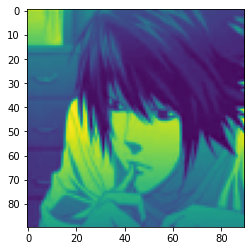

In [611]:
uploadYourImageHere(r'C:\Users\super\Pictures\Saved Pictures\Ryuuzaki.png')